# Quiz 2 - Visão Computacional

Aluno: Lucas Resende Pellegrinelli Machado

Matrícula: 2018126673

## 1. Abrindo a imagem e definindo a posição das quinas na imagem

Nesse primeiro bloco de código carregamos a imagem ```jupyter_images/photo.jpg``` e utilizando um software de ediçao de imagens, foram encontradas as posições de algumas quinas entre quadriculados na imagem. Essas posições estão armazenadas no vetor ```edge_points``` e as quinas estão sendo mostradas por meio de um plot.

Abaixo é possível observar o sistema de coordenadas escolhido para a imagem de calibração.

<img src="jupyter_images/coordinate_system.jpg" style="width: 50%">

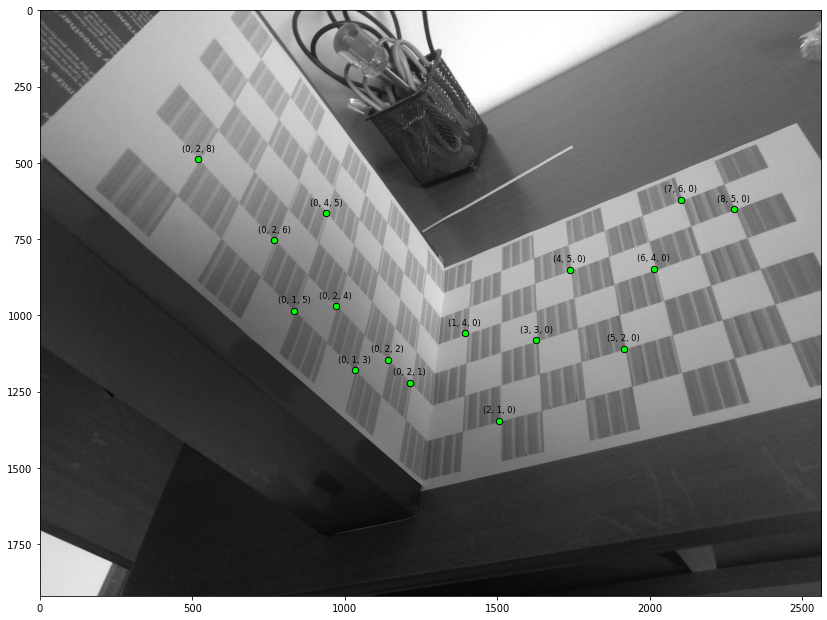

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

dx = 28 # mm
dy = 28 # mm

# [(x_pixel, y_pixel), (x_3d, y_3d, z_3d)]
edges = [
    [(1628, 1081), (3, 3, 0)],
    [(1737, 850), (4, 5, 0)],
    [(2014, 847), (6, 4, 0)],
    [(1507, 1345), (2, 1, 0)],
    [(1915, 1109), (5, 2, 0)],
    [(1395, 1058), (1, 4, 0)],
    [(2275, 651), (8, 5, 0)],
    [(2101, 621), (7, 6, 0)],
    [(769, 754), (0, 2, 6)],
    [(1214, 1221), (0, 2, 1)],
    [(1032, 1180), (0, 1, 3)],
    [(940, 665), (0, 4, 5)],
    [(835, 985), (0, 1, 5)],
    [(520, 489), (0, 2, 8)],
    [(970, 969), (0, 2, 4)],
    [(1141, 1145), (0, 2, 2)]
]

img = cv2.imread("jupyter_images/photo.jpg", 0)

plt.figure(figsize=(14, 14))
plt.imshow(img, cmap="gray")
    
for pos in edges:
    plt.scatter(x=pos[0][0], y=pos[0][1], color="black", s=40)
    plt.scatter(x=pos[0][0], y=pos[0][1], color="lime", s=20)
    plt.text(x=pos[0][0] - 55, y=pos[0][1] - 27, s=str(pos[1]), fontsize="small")
    
plt.show()

## 2. Implementação do algoritmo de calibração

No bloco abaixo está implementado toda a lógica correspondente ao algoritmo de calibração definido pelo livro ```Introductory techniques for 3-D computer_vision``` nas páginas ```129-132```.

1. Construa uma matrix $A$ cujas colunas são $(x_iX_i^w; x_iY_i^w; x_iZ_i^w; x_i; -y_iX_i^w; -y_iY_i^w; -y_iZ_i^w; -y_i)$
2. Faça o SVD dessa matriz $A$
3. Encontre o índice do valor nulo no vetor $D$
4. Guarde o vetor coluna da matriz $V$ com índice igual ao índice encontrado em **3.**. Esse vetor será chamado de $v$.
5. Descubra o valor de $|\gamma| = \sqrt{v_1^2 + v_2^2 + v_3^2}$
6. Descubra o valor de $\alpha = \frac{\sqrt{v_5^2 + v_6^2 + v_7^2}}{|\gamma|}$
7. Como $v = \gamma (r_{21}; r_{22}; r_{23}; T_y; \alpha r_{11}; \alpha r_{12}; \alpha r_{13}; \alpha T_x)$ e como já sabemos o valor de $|\gamma|$, podemos saber o valor de $(T_x, T_y)$ e das 2 primeiras linha da matriz de rotação $R$ (porém sem garantia de sinal)
8. Com as 2 primeiras linhas da matriz $R$, podemos calcular a terceira e última linha por meio do produto vetorial entre as 2 primeiras
9. Para descobrir se precisaremos inverter o sinal das linhas de $R$ e de $(T_x, T_y)$ testaremos se $x (r_{11}X^w + r_{12}Y^w + r_{13}Z^w + T_x) > 0$. Caso verdadeiro, teremos que inverter os sinais, caso contrário, nada precisa ser feito
10. Para garantir a ortogonalidade de $R$, calcularemos o SVD dessa matriz e reconstruiremos ela a partir de seus componentes tal que $R = UV^T$
11. Para encontrar $(T_z, f_x)$ temos que resolver o sistema $A (T_z, f_x)^T = b$ tal que $A = (x_i; (r_{11}X_i^w + r_{12}Y_i^w + r_{13}Z_i^w + T_x))$ e $b = (-x_i (r_{31}X_i^w + r_{32}Y_i^w + r_{33}Z_i^w + T_x))$. Para fazer isso, basta calcular $(T_z, f_x)^T = (A^T A)^{-1} A^T b$

In [2]:
xi = np.array([p[0][0] for p in edges])
yi = np.array([p[0][1] for p in edges])
Xw = np.array([p[1][0] for p in edges]) * dx
Yw = np.array([p[1][1] for p in edges]) * dy
Zw = np.array([p[1][2] for p in edges]) * dx

# Constrói a matriz A que será jogada no SVD
A = np.array([
    xi * Xw,
    xi * Yw,
    xi * Zw,
    xi,
    -yi * Xw,
    -yi * Yw,
    -yi * Zw,
    -yi
]).T

# Calcula o SVD de A
U, D, V = np.linalg.svd(A)

# Encontra o valor nulo em D e guarda o índice desse valor
null_value_index = np.where(D == np.min(np.abs(D)))[0][0]

# Pega a coluna de V com índice igual ao índice do valor nulo em D
v_hat = V.T[:, null_value_index]

# |γ| = √(v_1^2 + v_2^2 + v_3^2)
mod_gamma = np.linalg.norm(v_hat[:3])

# α|γ| = √(v_5^2 + v_6^2 + v_7^2)
alpha = np.linalg.norm(v_hat[4:7]) / mod_gamma

# v_hat = γ * (r21 r22 r23 Ty α*r11 α*r12 α*r13 α*Tx)
R = np.empty((3, 3))
R[1] = v_hat[:3]          / mod_gamma
Ty   = v_hat[3]           / mod_gamma
R[0] = v_hat[4:7] / alpha / mod_gamma
Tx   = v_hat[7]   / alpha / mod_gamma

# A terceira linha da matriz de rotação é o produto vetorial das 2 primeiras
R[2] = np.cross(R[0], R[1])

# Reconstruindo R a partir de seus componentes SVD para enforçar a ortogonalidade de R
U_R, D_R, Vt_R = np.linalg.svd(R)
R = U_R @ Vt_R

# Aplicando a inversão de sinal caso necessário
if xi[0] * (R[0, 0] * Xw[0] + R[0, 1] * Yw[0] + R[0, 2] * Zw[0] + Tx) > 0:
    R[0] *= -1
    R[1] *= -1
    Tx *= -1
    Ty *= -1

# Descobrindo criando A e b para o calculo de fx e Tz
A = np.array([
    xi,
    R[0, 0] * Xw + R[0, 1] * Yw + R[0, 2] * Zw + Tx * np.ones(len(xi))
]).T

b = np.array([-xi * (R[2, 0] * Xw + R[2, 1] * Yw + R[2, 2] * Zw)]).T

# (Tz fx) = (At A)^-1 At b
[[Tz], [fx]] = np.linalg.inv(A.T @ A) @ A.T @ b

T = (Tx, Ty, Tz)
f = (fx, fx / alpha)

print("|γ| =", mod_gamma)
print(" α  =", alpha)
print(" T  =", T)
print(" f  =", f)

|γ| = 0.0029528869505027625
 α  = 1.0284202468422226
 T  = (-208.61816356235147, -262.0160242959757, 239.92651287471875)
 f  = (1365.107849796099, 1327.3832890665853)


## 3. Algoritmo de calibraçao Octave (Matlab)

Foi foi feita a calibração da câmera utilizada por meio do software Octave recomendado nas aulas por meio de 8 fotos do padrão usado acima. Apenas 1 dos papéis impressos foi utilizado para as fotos tiradas visto que esse é o jeito correto de utilizar a ferramenta.

<img src="jupyter_images/octave_calib.png" style="width: 50%">

Os resultados da calibração podem ser observados a seguir

<img src="jupyter_images/octave_result.png">

## 4. Algoritmo "Naive" para calibração

Também foram feitos testes com o método ingênuo para a calibração. Primeiro foi tirada a foto de um livro com a camera perpendicular a capa do livro. Em seguida a quantidade de pixels em cada dimensão do livro na foto foi obtida assim como as dimensões reais do livro e a distância entre o livro e a camera.

<img src="jupyter_images/livro_marcado.png" style="width: 50%">

O livro tem dimensões $16cm \hspace{0.1cm} x \hspace{0.1cm} 23cm$ e a foto foi tirada a $45cm$ do mesmo. Dessa forma, calculamos que a distância focal da câmera baseado nessa métrica é

$$f_x = \frac{328px \times 45cm}{16cm} = 922.5$$

$$f_y = \frac{471px \times 45cm}{23cm} = 921.5$$

## 5. Conclusão

Após testar os 3 diferentes métodos de calibração, é possível perceber que a complexidade deles pode variar drásticamente dependendo da precisão desejada pelo usuário final. Como esperado, o algoritmo Naive teve o resultado mais destoante dos 3, ainda que eu espero que em um caso médio essa diferença seja menor do que a apresentada aqui visto que para conseguir tirar a foto de maneira adequada tive que levar o celular a uma distância consideravelmente grande do livro o que acabou fazendo-o pequeno na foto, aumentando a imprecisão da contagem de pixels.

Os outros dois métodos, o implementado e o disponibilizado pela ferramenta da Octave, ficaram com resultados bem próximos, com uma distância percentual de apenas $5\%$, o que é razoavelmente esperado visto que o método das duas requereu imagens completamente diferentes para seus cálculos, e com um sample size "pequeno" em ambos os casos (16 pontos no algoritmo implementado e 8 fotos para o algoritmo Octave), pequenas diferenças são esperadas.

No geral, os resultados foram bons e a atividade cumpriu o propósito de reforçar os conhecimentos obtidos durante as aulas sobre a calibragem de câmeras e os parâmetros envolvidos nessa tarefa.